## Authors - Prateek & Martin

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import covid19sim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from collections import defaultdict

from covid19sim.plotting.plot_rt import PlotRt
from utils import plot_intervention


In [4]:

def absolute_file_paths(directory):
    to_return = []
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            if ".pkl" in f:
                to_return.append(os.path.abspath(os.path.join(dirpath, f)))
    return to_return


In [5]:
def plot_line_with_bounds(df, ax, color, label, mobility=False, **kwargs):
    # params
    linestyle = kwargs.get("linestyle", "-")
    alpha = kwargs.get("alpha", 1.0)
    marker = kwargs.get("marker", None)
    markersize = kwargs.get("markersize", 1)
    linewidth = 3
    
    index = np.array(list(range(df.shape[0])))
    mean = df.mean(axis=1)
    stderr = df.std(axis=1)/np.sqrt(df.shape[1])
    lows = mean - stderr
    highs = mean + stderr
    lowfn = interp1d(index, lows, bounds_error=False, fill_value='extrapolate')
    highfn = interp1d(index, highs, bounds_error=False, fill_value='extrapolate')
    
    ax.plot(mean, color=color, alpha=0.8*alpha, linestyle=linestyle, 
                linewidth=linewidth, label=label, marker=marker, ms=markersize)
    ax.fill_between(index, lowfn(index), highfn(index), color=color, alpha=.05, lw=0, zorder=3)
    
    return ax
    

In [6]:
def get_constants(filenames):
    _tmp = pickle.load(open(filenames[-1][0], "rb"))
    intervention_day = _tmp['intervention_day']
    n_init_infected = _tmp['n_init_infected']
    n_humans = _tmp['n_humans']
    return intervention_day, n_init_infected, n_humans


In [7]:
def get_perc_high_risk(data):
    degree_of_restriction = defaultdict(int)
    for d in data['risk_attributes']:
        risk_level = d['risk_level']
        timestamp = d['timestamp']
        if risk_level >= 2:
            degree_of_restriction[str(timestamp.date())] += 1

    deg = {}
    for k, v in degree_of_restriction.items():
        # percent of population who are high risk = sum hourly / 24 / pop size * 100
        perc_high_risk = v / 24 / 1000 * 100
        deg[k] = perc_high_risk
    return [0 for i in range(5)] + list(deg.values())

In [8]:

def plot(filenames, show_mobility=True, end_day=20):

    # constants
    intervention_day, n_init_infected, n_humans = get_constants(filenames)
    colormap = ["#34495e",  "mediumvioletred", "darkorange", "orangered", "royalblue", "green", "purple", "yellow", "pink"]
    title ="Comparison of Tracing Methods (60% Adoption Rate)"
    labels = ["Transformer (SKILLED-WATER)", "Binary contact tracing app (order 1)", "Binary contact tracing app (order 2)", "Oracle", "MLP high dropin", "lr high dropin", "Unmitigated"] 
    y_label_name = "% Population Infected"
    x_label_name = "Days since outbreak"
    dual_y_label_name = "Mobility"

    # plot
    fig, (ax, rax) = plt.subplots(nrows=2, ncols=1, figsize=(15,14), sharex=True, dpi=500)
    if show_mobility:
        dual_ax = ax.twinx()
        dual_ax.invert_yaxis()

    else:
        dual_ax = None

    for c, filelist in enumerate(filenames):
        ax, dual_ax = plot_group_cases(filelist, ax, dual_ax, show_mobility=show_mobility, color=colormap[c], end_day=end_day, label=labels[c])
    for c,filelist in enumerate(filenames):
        rax = plot_group_R(filelist, rax, color=colormap[c], end_day=end_day, label=labels[c])


    # intervention line
    if intervention_day > 0:
        ax.axvline(x=intervention_day-1, linestyle="-.", linewidth=3, alpha=0.6)
        ax.annotate("Intervention", xy=(intervention_day-1.8, 4), xytext=(intervention_day-1.8, 2.), size=20, rotation="vertical")

        # Rt
        rax.axvline(x=intervention_day-1, linestyle="-.", linewidth=3, alpha=0.6)
        rax.axhline(y=1.0, linestyle="-.", linewidth=3, color="green", alpha=0.3)
        rax.annotate("$R_t$ = 1.0", xy=(intervention_day, 1.0), xytext=(intervention_day -5 , 1.10), size=20, rotation="horizontal")

    # doubling every three days
    y_vals = [1.0*min(n_init_infected * pow(2, y/3), n_humans)/n_humans for y in range(0, end_day+1)]
    if show_mobility:
        ax.plot(range(1, len(y_vals)+1), y_vals, '-.', color="gray", alpha=0.3)

    # grid and ticks
    for x in [ax, rax]:
        x.grid(True, axis='x', alpha=0.3)
        x.grid(True, axis='y', alpha=0.3)
        x.tick_params(labelsize=25)

    rax.set_ylim(0, 4)
    if show_mobility:
        dual_ax.set_ylim(0, 100)
        dual_ax.tick_params(labelsize=25)

    # legends
    legends = ax.get_legend_handles_labels()
    legends, legend_labels = legends[0][:len(labels)], legends[1][:len(labels)]
    if show_mobility:
        line1 = Line2D([0], [0], color="black", linewidth=2, linestyle='--', label="mobility")
        line2 = Line2D([0], [0], color="black", linewidth=2, linestyle='-', label="% infected")
    ax.legend(legends, legend_labels, prop={"size":20}, loc="upper left")

    legends = rax.get_legend_handles_labels()
    rax.legend(legends[0], legends[1],  prop={"size":20}, loc="upper right")

    # labels 
    ax.set_ylabel(y_label_name, fontsize=25, labelpad=20)
    if show_mobility:
        dual_ax.set_ylabel(dual_y_label_name, fontsize=25, labelpad=30, rotation=270)

    rax.set_ylabel("$R_t$", fontsize=25, labelpad=20)

    # plot
    rax.set_xlabel(x_label_name, fontsize=20)
    rax.set_xticks(np.arange(0,20,2))
    fig.suptitle(title, fontsize=30 )
    
    return fig


In [9]:
# assumption - all lists have same size
def plot_group_cases(filenames, ax, dual_ax, show_mobility=True, color="red", end_day=None, label=""):
    cases, mobile = [], []
    if not label:
        label = filenames[0][:-3].split("_")[-1].split(".")[0]

    for i, filename in enumerate(filenames):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        n_init_infected = data['n_init_infected']
        n_humans = data['n_humans']
        cases_per_day = np.cumsum(data['cases_per_day'])[:end_day]
        cases_per_day += n_init_infected
        cases_per_day = cases_per_day / n_humans * 100
        cases.append(cases_per_day)
        mobile.append(get_perc_high_risk(data))
    cases = pd.DataFrame(cases).transpose()
    
    ax = plot_line_with_bounds(cases, ax, color, label)
    if show_mobility:
        mobile = pd.DataFrame(mobile).transpose()
        dual_ax = plot_line_with_bounds(mobile, dual_ax, color, label, show_mobility=True, linestyle="--", alpha=0.3)

    return ax, dual_ax

def plot_group_R(filenames, ax, color="red", end_day=None, label=""):
    if not label:
        label = filenames[0][:-3].split("_")[-1].split(".")[0]
    
    Rt = []
    for i, filename in enumerate(filenames):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        
        output_r = data['R']
        for idx, r in enumerate(output_r):
            if r > 0:
                break
                
        cases_per_day = data['cases_per_day'] [:end_day+4]
        if data['serial_interval'] > 0:
            serial_interval = data['serial_interval']
        else:
            serial_interval = 7.0
            print("WARNING: serial_interval is 0")
        
        print(f"using serial interval :{serial_interval}")
        plotrt = PlotRt(R_T_MAX=4, sigma=0.25, GAMMA=1.0/serial_interval)
        most_likely, _ = plotrt.compute(cases_per_day, r0_estimate=2.5)
        Rt.append(most_likely[:end_day].tolist())

    Rt = pd.DataFrame(Rt).transpose()
    ax = plot_line_with_bounds(Rt, ax, color, label, linestyle=":", marker="P", markersize=5)
    return ax

In [10]:

filenames_transformer = absolute_file_paths("../data/low_dropin_3k/SKILLED-WATER-520/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
filenames_bdt1_07 = absolute_file_paths("../data/low_dropin_3k/BDT1/APP_UPTAKE_0.0705/P_CAREFUL_PERSON_0.3/")
filenames_bdt1_42 = absolute_file_paths("../data/low_dropin_3k/BDT1/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
filenames_bdt1_84 = absolute_file_paths("../data/low_dropin_3k/BDT1/APP_UPTAKE_0.8415/P_CAREFUL_PERSON_0.3/")
# filenames_bdt2 = absolute_file_paths("../data/low_dropin_3k/BDT2/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
# filenames_oracle = absolute_file_paths("../data/low_dropin_3k/ORACLE/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
# filenames_mlp_high_dropin = absolute_file_paths("../data/low_dropin_3k/DAILY-GALAXY-438/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
# filenames_lr_high_dropin = absolute_file_paths("../data/low_dropin_3k/DARK-DISCO-437/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
# filenames_unmitigated = absolute_file_paths("../data/low_dropin_3k/UNMITIGATED/APP_UPTAKE_0.4215/P_CAREFUL_PERSON_0.3/")
filenames = [filenames_bdt1_07, filenames_bdt1_42, filenames_bdt1_84]
# filenames = [filenames_transformer, filenames_bdt1, filenames_bdt2, filenames_oracle, filenames_mlp_high_dropin, filenames_lr_high_dropin, filenames_unmitigated]

In [11]:
figure_filename_en = "covi_method_comparison_degree_of_restriction_risk_5_en.pdf"
figure_filename_fr = "covi_method_comparison_degree_of_restriction_fr.pdf"


using serial interval :5.22044980637474
using serial interval :5.1533330631214875
using serial interval :5.140433710472875
using serial interval :5.067941886899687
using serial interval :5.148695667818077
using serial interval :5.074263558915287
using serial interval :4.9033137254901975
using serial interval :5.164760378510379
using serial interval :5.3355721393034825


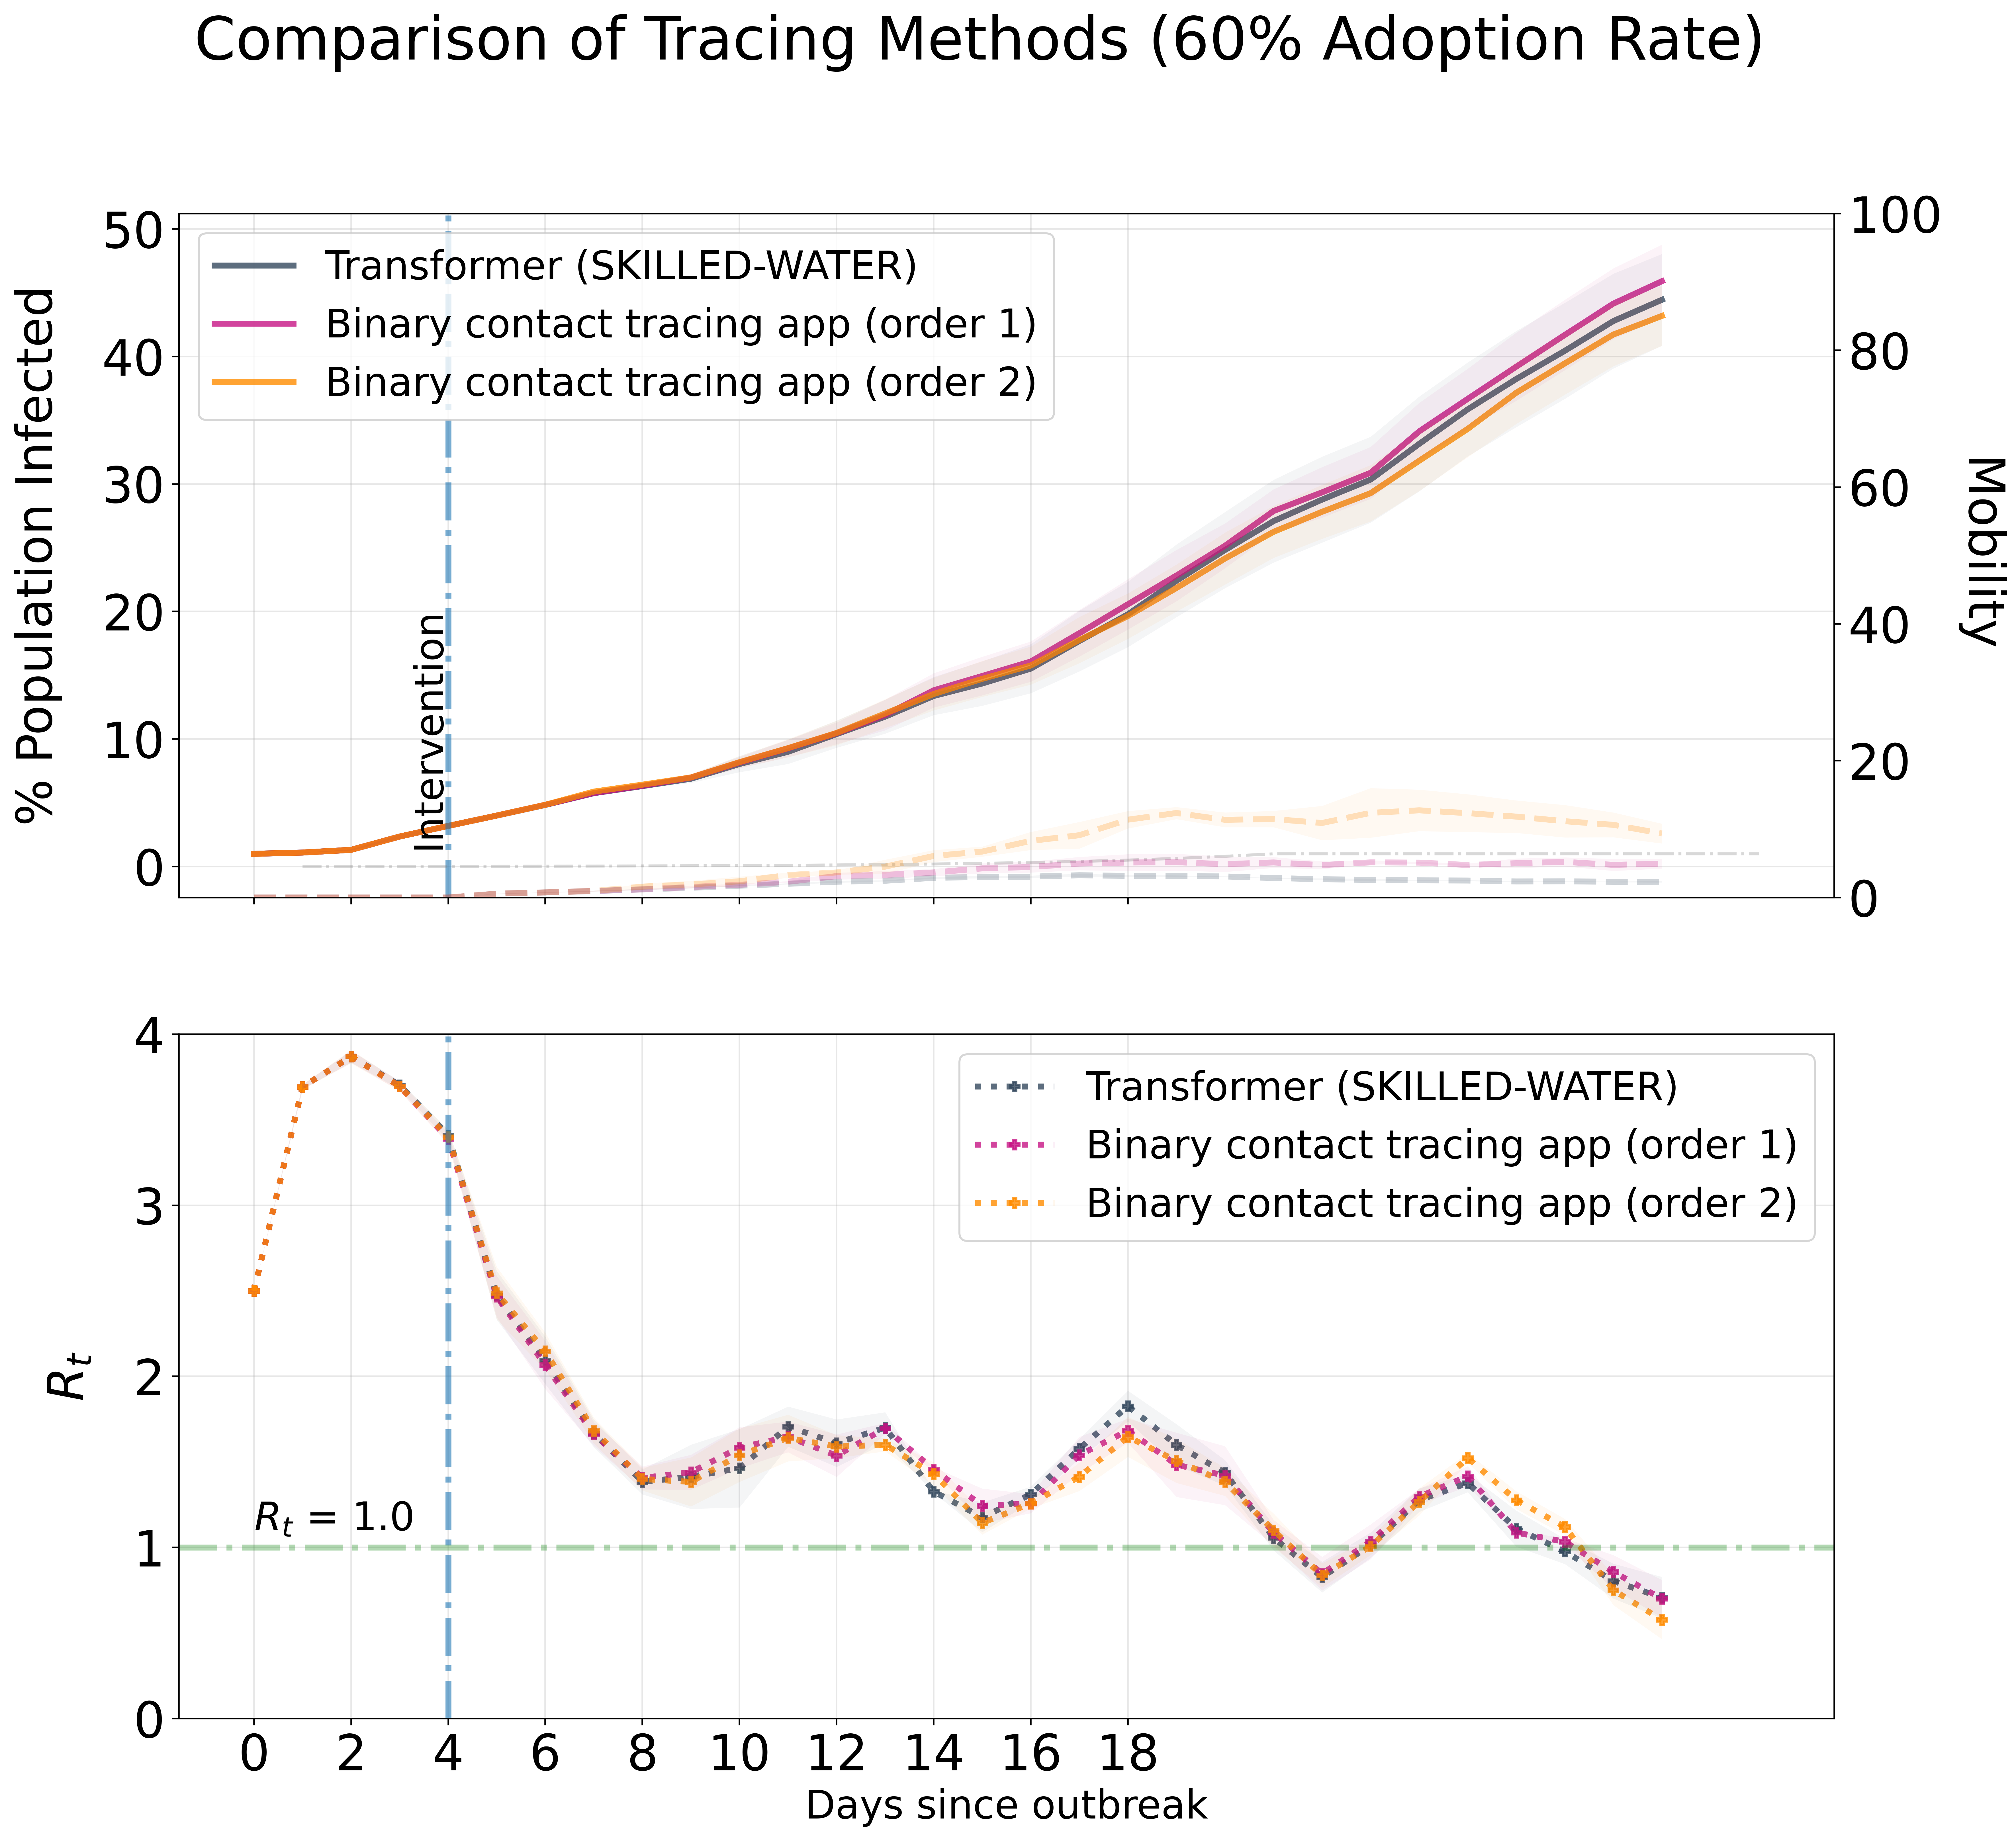

In [12]:
fig = plot(filenames=filenames, show_mobility=True, end_day=30)
fig.savefig(figure_filename_en) 
